In [3]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [6]:
# create engine to hawaii.sqlite
engine = create_engine(f"sqlite:///hawaii.sqlite")
conn = engine.connect()

In [7]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [8]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)


In [9]:
# View all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [10]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [16]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [12]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [13]:
# Find the most recent date in the data set.
results = session.query(Measurement.date).\
    order_by(Measurement.date.desc()).first()
print(results)

('2017-08-23',)


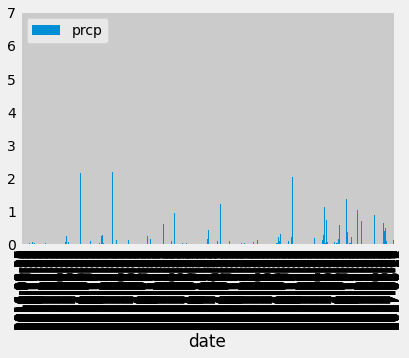

In [30]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
#print(year_ago)

# Perform a query to retrieve the date and precipitation scores
start_date = dt.datetime(2016, 8, 23)
end_date = dt.datetime(2017, 8, 23)

results = session.query(Measurement.prcp, 
                        Measurement.date).\
                  filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

#print(results)
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results).set_index("date")

# Sort the dataframe by date
df.sort_values(by=['date'])

# Use Pandas Plotting with Matplotlib to plot the data
df = pd.DataFrame(results)
df.set_index('date', inplace=True)
df.plot.bar()
#plt.tight_layout()
plt.show()



In [ ]:
# Use Pandas to calcualte the summary statistics for the precipitation data


# Exploratory Station Analysis

In [ ]:
# Design a query to calculate the total number stations in the dataset


In [ ]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.


In [ ]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.


In [ ]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


# Close session

In [ ]:
# Close Session
session.close()